<center><h1><font color="orange">Deep Dream</font></h1></center>

<h4>Imports:</h4>

In [6]:
#General 
from __future__ import print_function
import time
import argparse
import glob

#Data Handling 
import numpy as np

#Image Handling
from scipy.misc import imsave
from keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
from PIL import Image

#Deep Learning
from keras.applications import vgg16
from keras import backend as K 
from keras.layers import Input

#Optimization 
from scipy.optimize import fmin_l_bfgs_b

<h4>Step 1: Settings for Model:</h4>
<p>Select the image, place to save the results, the dimensions of the generated image, the number of iterations for optimization, and the layer settings in the VGG16 model.</p>

In [12]:
#Content Image
base_image_path = "content_images/tech_tower.jpg"

#Where to save deep generated images
result_prefix = "deep_dream_results/deep_dream"

# dimensions of the generated picture
img_width = 800
img_height = 800

#number of minimization iterations
iters = 15

#VGG16 layer settings 
saved_settings = {
    'bad_trip': {'features':{'block4_conv1': 0.05,
                            'block4_conv2': 0.01,
                            'block4_conv3': 0.01},
                'continuity': 0.01,
                'dream_l2': 0.8,
                'jitter': 5},
    'dreamy': {'features': {'block5_conv1':0.05,
                            'block5_conv2': 0.02},
                'continuity': 0.1,
                'dream_l2': 0.02,
                'jitter': 0},
    }

# the settings we will use in this experiment
settings = saved_settings['dreamy']

<h4>Step 2: Image Handling</h4>
<p>Create functions to turn an image into a tensor and a tensor into an image.</p>

In [4]:
# util function to open, resize and format picturs into appropriate tensors.
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(img_width, img_height))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg16.preprocess_input(img)
    return img

# util function to convert a tensor into a valid image
def deprocess_image(x):
    if K.image_dim_ordering() == 'th':
        x = x.reshape((3, img_width, img_height))
        x = x.transpose((1,2,0))
    else:
        x = x.reshape((img_width, img_height, 3))

    # remove zero-center by mean pixel
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] ++ 123.68

    # BGR -> RGB
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

<h4>Step 3: Load Model</h4>
<p>Check the backend of Keras (theano v.s. tensorflow), set an input for the generated image, and load the VGG16 model.</p>

In [5]:
if K.image_dim_ordering() == 'th':
    img_size = (3, img_width, img_height)
else:
    img_size = (img_width, img_height, 3)
    
# this will contain our generated image
dream = Input(batch_shape=(1,) + img_size)
# build the VGG16 network with our placeholder
# the model will be loaded with pre-trained ImageNet weights
model = vgg16.VGG16(input_tensor=dream,
                    weights='imagenet', include_top=False)

<h4>Step 4: Get Layer Names</h4>
<p>Create a dictionary of layer names in our model.</p>

In [7]:
# get the symbolic outputs of each "key" layer (we gave them unique names).
layer_dict = dict([(layer.name, layer) for layer in model.layers])

<h4>Step 5: Loss</h4>
<p>Define the loss.</p>

In [8]:
# continuity loss util function
def continuity_loss(x):
    assert K.ndim(x) == 4
    if K.image_dim_ordering() == 'th':
        a = K.square(x[:, :, :img_width - 1, :img_height - 1] -
                     x[:, :, 1:, :img_height - 1])
        b = K.square(x[:, :, :img_width - 1, :img_height - 1] -
                     x[:, :, :img_width - 1, 1:])
    else:
        a = K.square(x[:, :img_width - 1, :img_height-1, :] -
                     x[:, 1:, :img_height - 1, :])
        b = K.square(x[:, :img_width - 1, :img_height-1, :] -
                     x[:, :img_width - 1, 1:, :])
    return K.sum(K.pow(a + b, 1.25))

# define the loss
loss = K.variable(0.)
for layer_name in settings['features']:
    # add the L2 norm of the features of a layer to the loss
    assert layer_name in layer_dict.keys(), 'Layer ' + layer_name + ' not found in model.'
    coeff = settings['features'][layer_name]
    x = layer_dict[layer_name].output
    shape = layer_dict[layer_name].output_shape
    # we avoid border artifacts by only involving non-border pixels in the loss
    if K.image_dim_ordering() == 'th':
        loss -= coeff * K.sum(K.square(x[:, :, 2: shape[2] - 2, 2: shape[3] - 2])) / np.prod(shape[1:])
    else:
        loss -= coeff * K.sum(K.square(x[:, 2: shape[1] - 2, 2: shape[2] - 2, :])) / np.prod(shape[1:])

# add continuity loss (gives image local coherence, can result in an artful blur)
loss += settings['continuity'] * continuity_loss(dream) / np.prod(img_size)
# add image L2 norm to loss (prevents pixels from taking very high values, makes image darker)
loss += settings['dream_l2'] * K.sum(K.square(dream)) / np.prod(img_size)

<h4>Step 6: Compute Gradients</h4>
<p>Compute the gradients with respect to the loss.</p>

In [9]:
# compute the gradients of the dream wrt the loss
grads = K.gradients(loss, dream)

outputs = [loss]
if type(grads) in {list, tuple}:
    outputs += grads
else:
    outputs.append(grads)

f_outputs = K.function([dream], outputs)
def eval_loss_and_grads(x):
    x = x.reshape((1,) + img_size)
    outs = f_outputs([x])
    loss_value = outs[0]
    if len(outs[1:]) == 1:
        grad_values = outs[1].flatten().astype('float64')
    else:
        grad_values = np.array(outs[1:]).flatten().astype('float64')
    return loss_value, grad_values

<h4>Step 7: Make Things Easier</h4>
<p>COmpute loss and gradients in one pass.</p>

In [10]:
# this Evaluator class makes it possible
# to compute loss and gradients in one pass
# while retrieving them via two separate functions,
# "loss" and "grads". This is done because scipy.optimize
# requires separate functions for loss and gradients,
# but computing them separately would be inefficient.
class Evaluator(object):
    def __init__(self):
        self.loss_value = None
        self.grad_values = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

evaluator = Evaluator()

<h4>Step 7: Optimize</h4>
<p>Use L-BFGS to minimize the loss.</p>

In [ ]:
# run scipy-based optimization (L-BFGS) over the pixels of the generated image
# so as to minimize the loss
x = preprocess_image(base_image_path)
for i in range(iters):
    print('Start of iteration', i)
    start_time = time.time()

    # add a random jitter to the initial image. This will be reverted at decoding time
    random_jitter = (settings['jitter'] * 2) * (np.random.random(img_size) - 0.5)
    x += random_jitter

    # run L-BFGS for 7 steps
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
                                     fprime=evaluator.grads, maxfun=7)
    print('Current loss value:', min_val)
    # decode the dream and save it
    x = x.reshape(img_size)
    x -= random_jitter
    img = deprocess_image(np.copy(x))
    fname = result_prefix + '_at_iteration_%d.png' % i
    imsave(fname, img)
    end_time = time.time()
    print('Image saved as', fname)
    print('Iteration %d completed in %ds' % (i, end_time - start_time))

<h4>Step 8: View Results</h4>
<p>View each iteration of the deep dream images.</p>

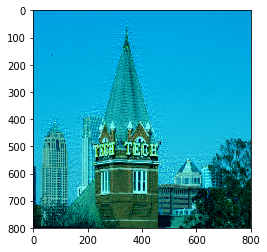

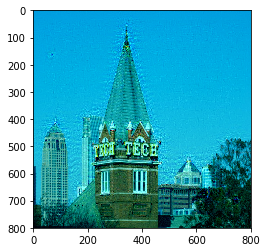

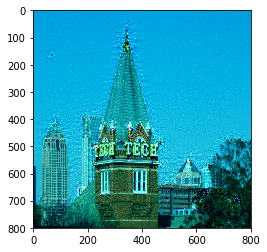

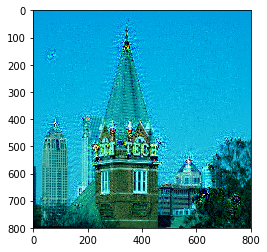

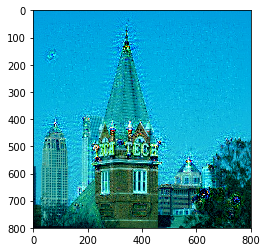

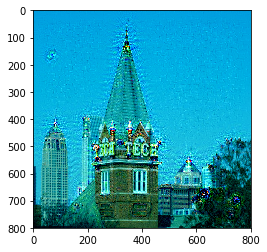

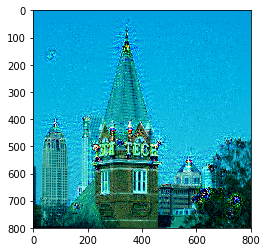

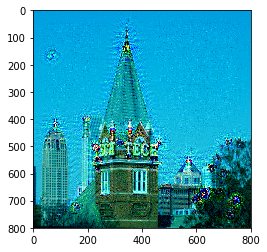

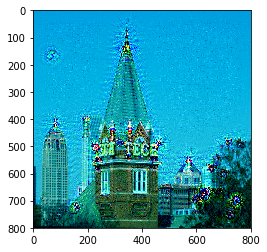

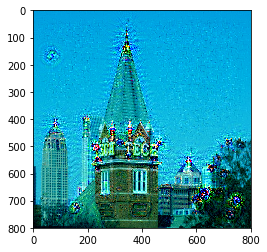

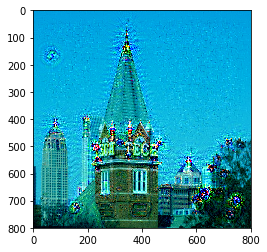

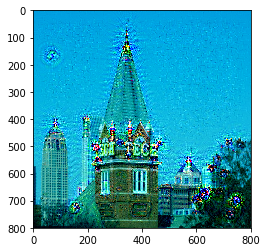

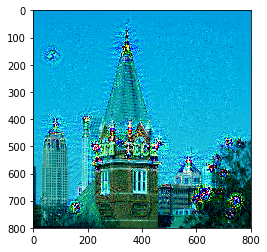

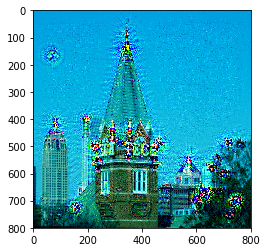

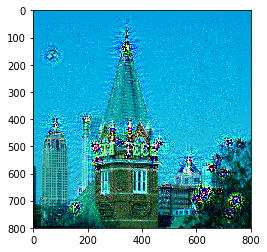

In [8]:
for i in range(15): 
    plt.imshow(Image.open("deep_dream_results/deep_dream_at_iteration_{}.png".format(i)))
    plt.show()

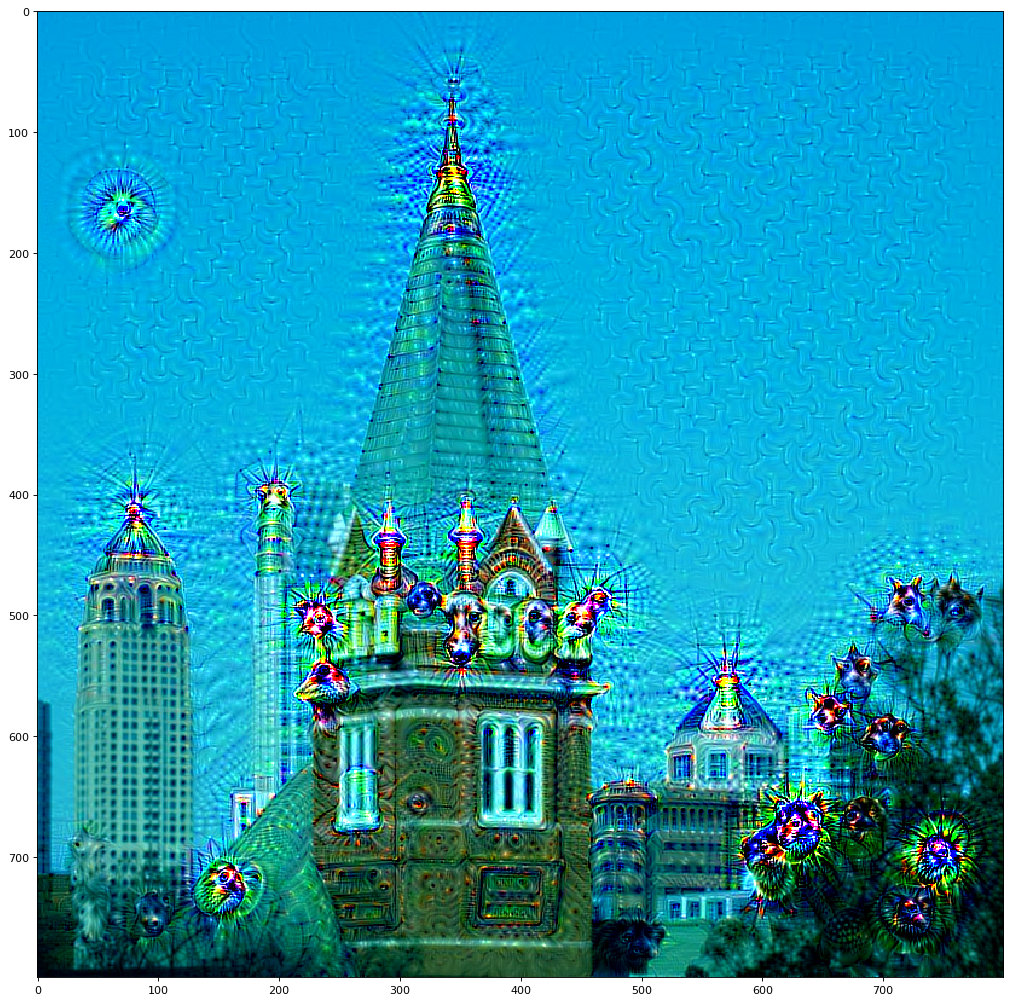

In [11]:
fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')

plt.imshow(Image.open("deep_dream_results/deep_dream_at_iteration_14.png"))
plt.show()